# How to use the `abscal` module of `hera_cal`
<br>
Jan. 2018
<br>
Nick Kern
<br>
nkern@berkeley.edu

---

In this tutorial, we show you one way you can use the absolute calibration capabilities of `hera_cal` to phase and scale data to an absolute reference. We use example data from HERA-47 observation, having extracted out a smaller sub-array from the data.

We do this both on data that has already had `omnical` calibration applied as well as on raw data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve

# Table of Contents

1. [Absolute Calibration of omnical'd data using constrained bandpass solvers](#Absolute-Calibration-of-omnical'd-data-using-constrained-bandpass-solvers)

1. [Absolute Calibration of raw data using general bandpass solvers](#Absolute-Calibration-of-raw-data-using-general-bandpass-solvers)

# Absolute Calibration of `omnical`'d data using constrained bandpass solvers

We start with data that has already been redundantly calibrated through `omnical`. We then select a model from a different night that has already been absolutely calibrated (using CASA and point source models) that lines up in LST with our data. We then use the ***constrained bandpass*** solvers in `hera_cal.abscal` to solve for the degenerate degrees of freedom missing in the `omnical` solution.

These constrained bandpass solvers are `abs_amp_lincal`, which solves for a single amplitude across all antennas that sets the flux scale, and `TT_phs_logcal`, which solves for the Tip-Tilt of the array and the overall phase scalar of the array.

In [2]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
(model, mflags, antpos, ants, model_freqs, model_times,
 model_pols) = hc.abscal.UVData2AbsCalDict([model_fname1, model_fname2], return_meta=True)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
(data, dflags, antpos, ants, data_freqs, data_times,
 data_pols) = hc.abscal.UVData2AbsCalDict(data_fname, return_meta=True)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

antloc = np.array(map(lambda k: antpos[k], ants))
bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])

(-30, 30)

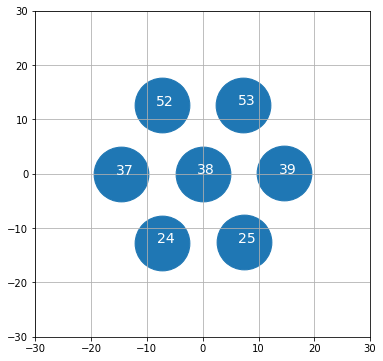

In [3]:
# plot sub-array HERA layout
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter(antloc[:, 0], antloc[:, 1], s=3000)
_ = [plt.text(antloc[i, 0]-1, antloc[i, 1], str(ants[i]), fontsize=14, color='w') for i in range(len(ants))]
plt.xlim(-30, 30)
plt.ylim(-30, 30)

## interpolate model onto time & freq axes of data

In [4]:
model, interp_flags = hc.abscal.interp2d_vis(model, model_times, model_freqs, data_times, data_freqs)

## Instantiate `AbsCal` object

In [5]:
# instantiate class
AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## plot model and data

divide by zero encountered in log10


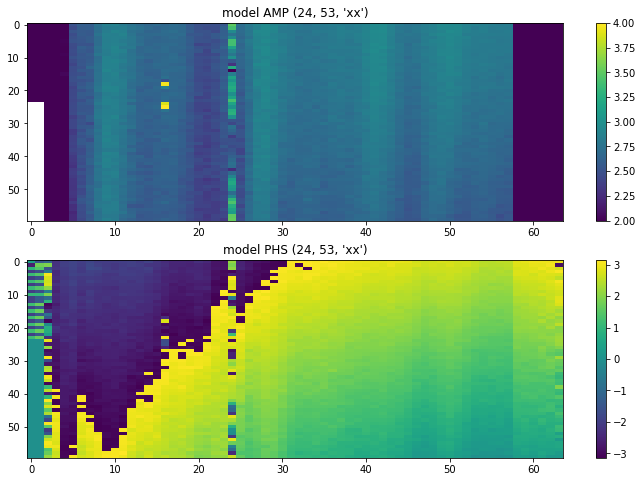

In [6]:
# plot model
bl = (24, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

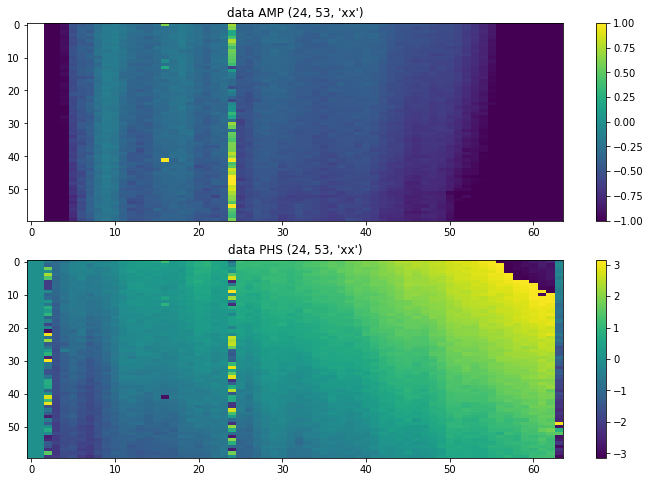

In [7]:
# plot data
bl = (24, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

## run delay solver and inspect gains

In [6]:
# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
AC.delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)

...configuring linsolve data for delay_lincal


divide by zero encountered in divide
invalid value encountered in divide


...running linsolve
...finished linsolve
...running linsolve
...finished linsolve


(-0.3, 0.3)

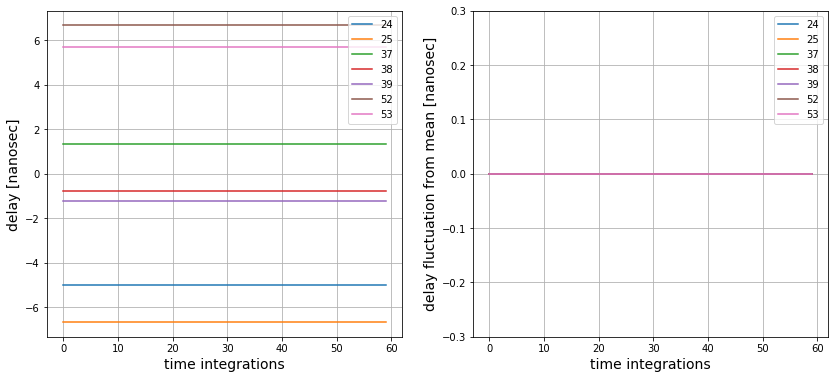

In [7]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.ant_dly_arr[:, :, 0, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)
ax.set_ylim(-0.3, 0.3)

In [13]:
# apply to data
delay_corr_data = hc.abscal.apply_gains(data, (AC.ant_dly_gain))#, AC.ant_dly_phi_gain))

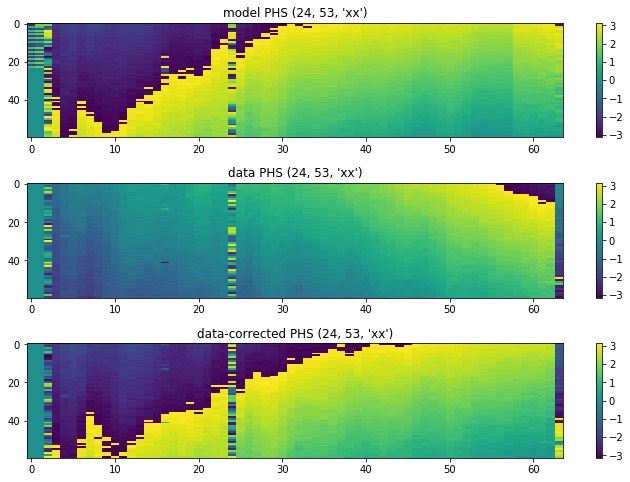

In [14]:
# inspect results data
bl = (24, 53, 'xx')
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(delay_corr_data[bl]*np.exp(-0.4j), mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

## reinstantiate `AbsCal` with delay-corrected data

In [15]:
# instantiate class
DAC = hc.abscal.AbsCal(model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## run absolute amplitude solver

In [16]:
# run amp linsolve
DAC.abs_amp_logcal()

...configuring linsolve data for abs_amp_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in log


...finished linsolve


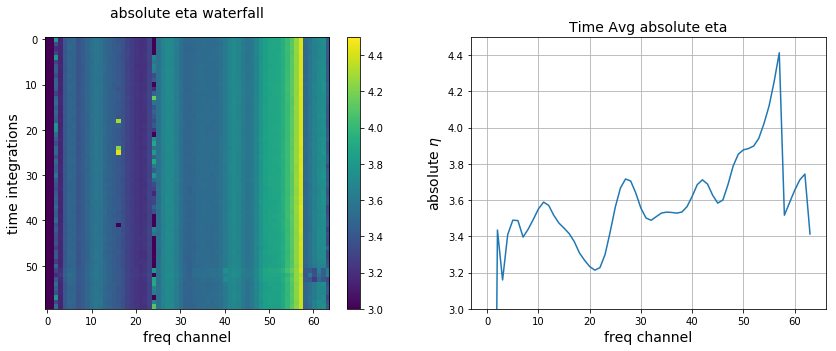

In [17]:
# inspect absolute scalar results
# plot gain amp
fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax = axes[0]
cax = ax.matshow(DAC.abs_eta_arr[0,:,:,0], aspect='auto', vmin=3, vmax=4.5)
fig.colorbar(cax, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('absolute eta waterfall', fontsize=14)

ax = axes[1]
ax.plot(np.median(DAC.abs_eta_arr[0,:,:,0], axis=0))
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('Time Avg absolute eta', fontsize=14)
ax.set_ylim(3, 4.5)
ax.set_ylabel(r'absolute $\eta$', fontsize=14)

## run tip-tilt phase solver

In [18]:
# run phs linsolve
DAC.TT_phs_logcal(zero_psi=False)

...configuring linsolve data for TT_phs_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


### plot overall phase

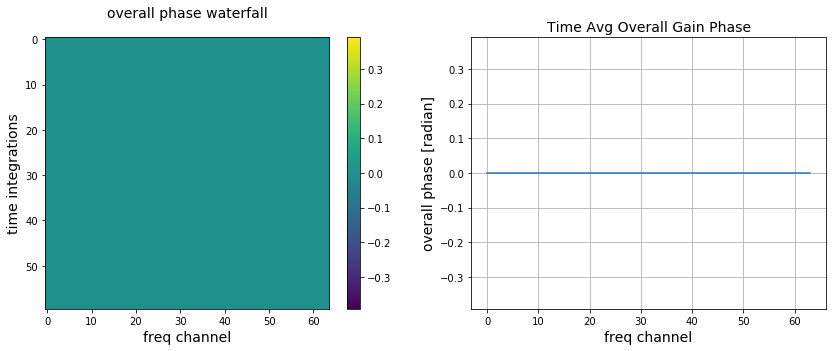

In [19]:
# plot psi
fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax = axes[0]
cax = ax.matshow(DAC.abs_psi_arr[0, :, :, 0], aspect='auto', vmin=-np.pi/8, vmax=np.pi/8)
fig.colorbar(cax, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('overall phase waterfall', fontsize=14)

ax = axes[1]
ax.plot(np.median(DAC.abs_psi_arr[0, :, :, 0], axis=0))
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('Time Avg Overall Gain Phase', fontsize=14)
ax.set_ylim(-np.pi/8, np.pi/8)
ax.set_ylabel('overall phase [radian]', fontsize=14)

### inspect tip-tilt phase

(-0.1, 0.1)

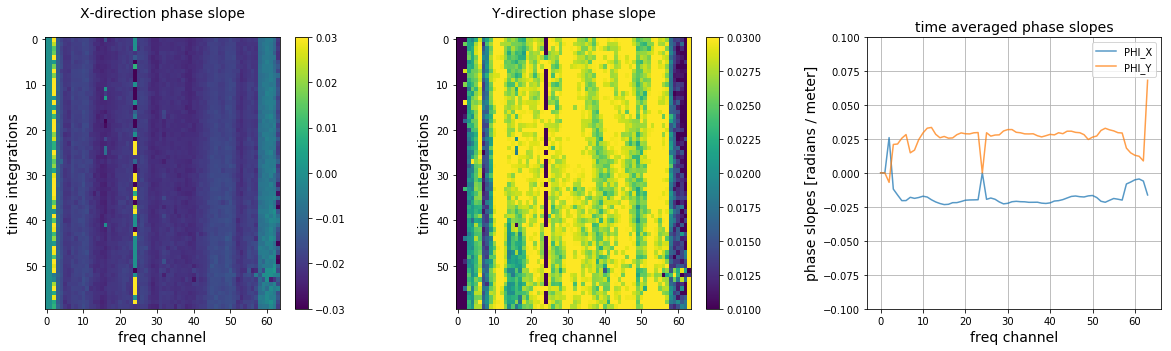

In [20]:
# plot gain phi
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
cax = ax.matshow(DAC.TT_Phi_arr[0, 0, :, :, 0], aspect='auto', vmin=-.03, vmax=0.03)
fig.colorbar(cax, ax=ax)
ax.set_title('PHI_X')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('X-direction phase slope', fontsize=14)

ax = axes[1]
cax = ax.matshow(DAC.TT_Phi_arr[0, 1, :, :, 0], aspect='auto', vmin=0.01, vmax=0.03)
fig.colorbar(cax, ax=ax)
ax.set_title('PHI_Y')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('Y-direction phase slope', fontsize=14)

ax = axes[2]
p0, = ax.plot(np.nanmedian(DAC.TT_Phi_arr[0, 0, :, :, 0], axis=0), alpha=0.75)
p1, = ax.plot(np.nanmedian(DAC.TT_Phi_arr[0, 1, :, :, 0], axis=0), alpha=0.75)
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('time averaged phase slopes', fontsize=14)
ax.set_ylabel('phase slopes [radians / meter]', fontsize=14)
ax.legend([p0,p1], ["PHI_X", "PHI_Y"])
ax.set_ylim(-.1, .1)

In [21]:
# apply to data
abs_corr_data = hc.abscal.apply_gains(DAC.data, (DAC.abs_psi_gain, DAC.TT_Phi_gain, DAC.abs_eta_gain), gain_convention='multiply')

divide by zero encountered in log10


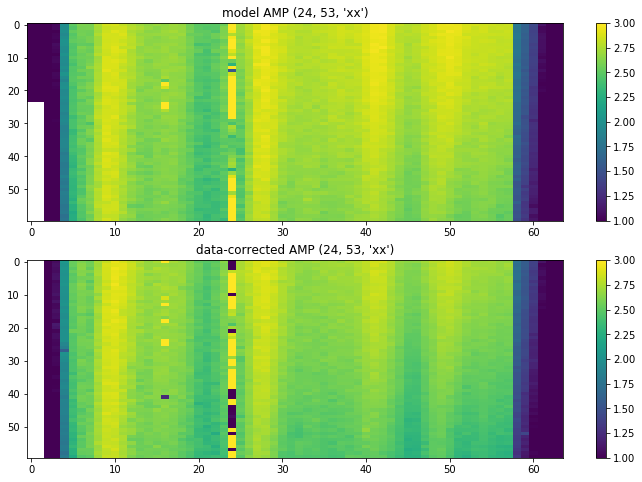

In [22]:
# plot model and data-corrected amplitude
bl = (24, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=3, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=3, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

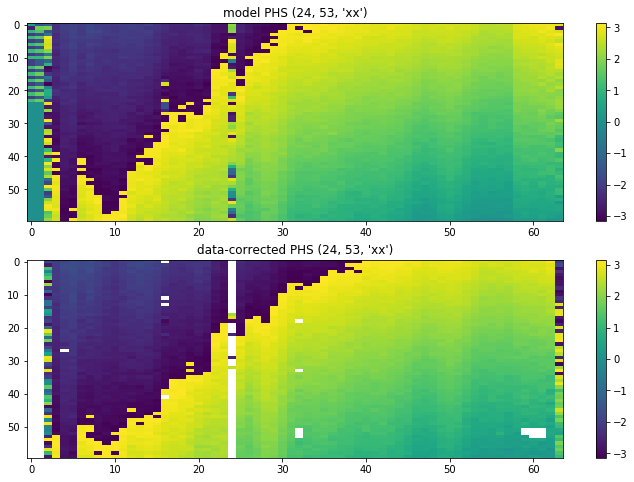

In [23]:
# plot model and data-corrected phase
bl = (24, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
d = abs_corr_data[bl]
d[~wgts[bl].astype(np.bool)] *= np.nan
uvt.plot.waterfall(d, mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

# Absolute Calibration of raw data using general bandpass solvers

This is essentially identical to our procedure before, but this time we start with raw data (rather than `omnical`'d data), and also we use the general bandpass solvers `amp_logcal` and `phs_logcal`, rather than the constrained bandpass solvers.

In [24]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
(model, mflags, antpos, ants, model_freqs, model_times,
 model_pols) = hc.abscal.UVData2AbsCalDict([model_fname1, model_fname2], return_meta=True)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvA")
(data, dflags, antpos, ants, data_freqs, data_times,
 data_pols) = hc.abscal.UVData2AbsCalDict(data_fname, return_meta=True)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

antloc = np.array(map(lambda k: antpos[k], ants))

In [25]:
model, interp_flags = hc.abscal.interp2d_vis(model, model_times, model_freqs, data_times, data_freqs)

In [26]:
# instantiate class
AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

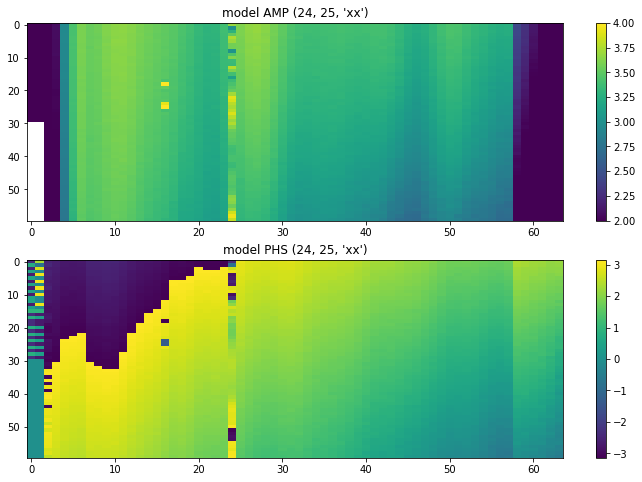

In [27]:
# plot model
bl = (24, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

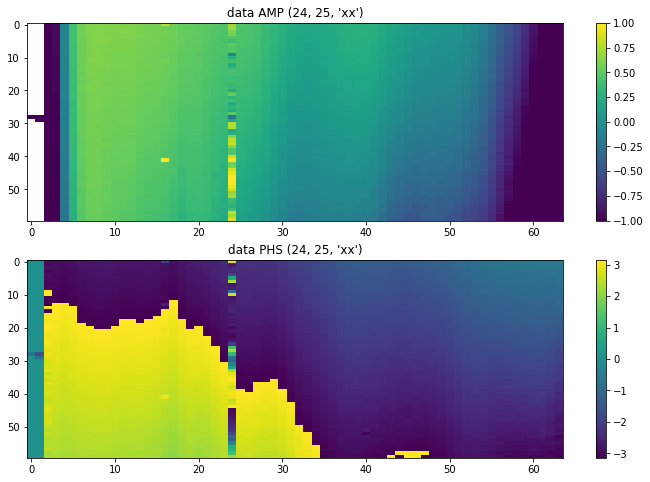

In [28]:
# plot data
bl = (24, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

In [29]:
AC.delay_lincal(time_avg=True, medfilt=True, solve_offsets=True)

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve


(-0.2, 0.2)

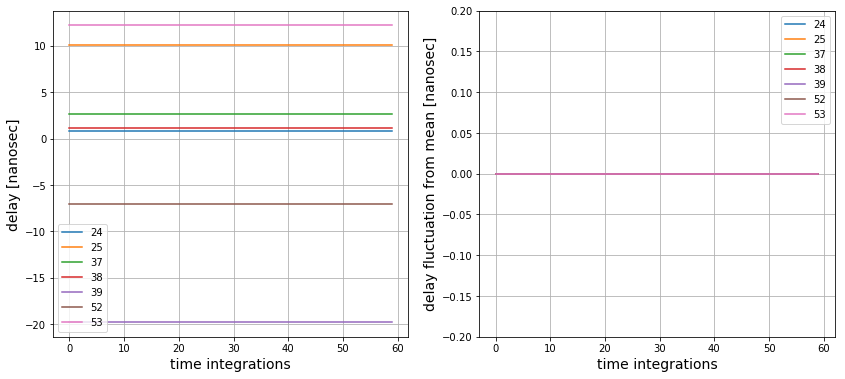

In [30]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.ant_dly_arr[:, :, 0, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)
ax.set_ylim(-0.2, 0.2)

In [48]:
# apply to data
delay_corr_data = hc.abscal.apply_gains(AC.data, (AC.ant_dly_gain, AC.ant_dly_phi_gain))

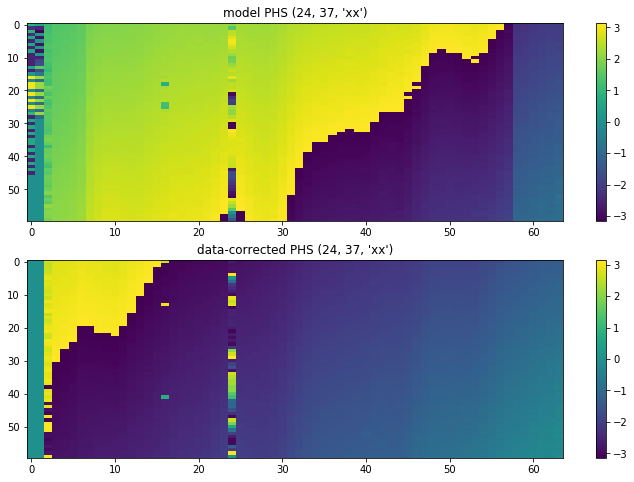

In [47]:
# plot model and data-corrected phase
bl = (24, 37, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(delay_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

In [50]:
# instantiate class
DAC = hc.abscal.AbsCal(AC.model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [51]:
# run amp logcal
DAC.amp_logcal()

...configuring linsolve data for amp_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in log


...finished linsolve


In [52]:
# run phase calibration
DAC.phs_logcal()

...configuring linsolve data for phs_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


In [53]:
# apply to data
abs_corr_data = hc.abscal.apply_gains(DAC.data, (DAC.ant_eta_gain, DAC.ant_phi_gain))

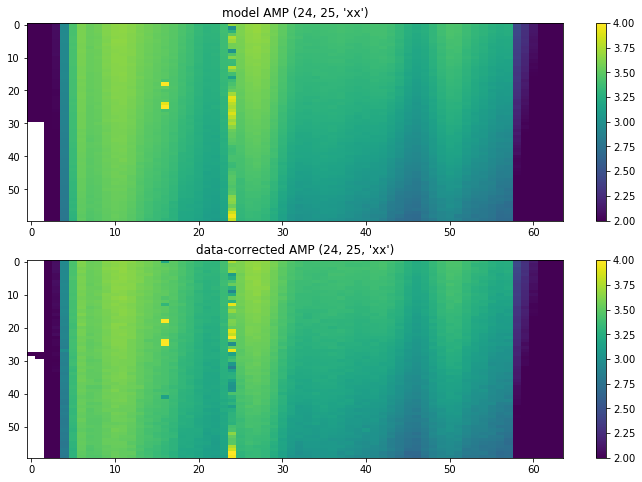

In [54]:
# plot model and data-corrected amplitude
bl = (24, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(DAC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

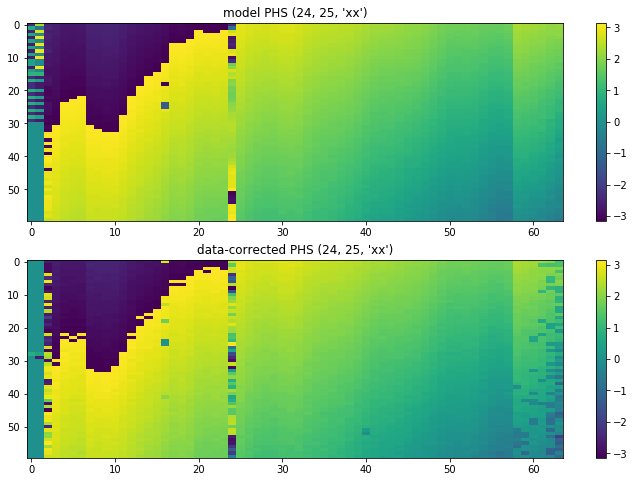

In [55]:
# plot model and data-corrected phase
bl = (24, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(DAC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))